# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Bien, usaste una celda independiente para importar las librerías y otra para leer los datos.
</div>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df_dup = df.index.duplicated().sum()
df_fal = df.index.isna().sum()

print(df_dup)
print(df_fal)

0
0


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Buen uso de los métodos de pandas para explorar los datos.
</div>

In [5]:
print(df.index[5:])

DatetimeIndex(['2018-03-01 00:50:00', '2018-03-01 01:00:00',
               '2018-03-01 01:10:00', '2018-03-01 01:20:00',
               '2018-03-01 01:30:00', '2018-03-01 01:40:00',
               '2018-03-01 01:50:00', '2018-03-01 02:00:00',
               '2018-03-01 02:10:00', '2018-03-01 02:20:00',
               ...
               '2018-08-31 22:20:00', '2018-08-31 22:30:00',
               '2018-08-31 22:40:00', '2018-08-31 22:50:00',
               '2018-08-31 23:00:00', '2018-08-31 23:10:00',
               '2018-08-31 23:20:00', '2018-08-31 23:30:00',
               '2018-08-31 23:40:00', '2018-08-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=26491, freq=None)


In [6]:
df = df.resample('1H').sum()

In [7]:
print(df.index[:10])

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 01:00:00',
               '2018-03-01 02:00:00', '2018-03-01 03:00:00',
               '2018-03-01 04:00:00', '2018-03-01 05:00:00',
               '2018-03-01 06:00:00', '2018-03-01 07:00:00',
               '2018-03-01 08:00:00', '2018-03-01 09:00:00'],
              dtype='datetime64[ns]', name='datetime', freq='H')


Dado que no había datos faltantes ni duplicados, se procedió al espaciado de datos por cada hora. A continuación, el análisis de los datos. 

In [8]:
print(df['num_orders'].describe())

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64


Se eliminan valores atípicos usando clipping.

In [9]:
df_1 = df.copy()

bajo = df_1['num_orders'].quantile(0.01)
alto = df_1['num_orders'].quantile(0.99)

df_1['num_orders'] = df_1['num_orders'].clip(lower=bajo, upper=alto)

print(df_1.describe())

        num_orders
count  4416.000000
mean     84.050045
std      43.221000
min       7.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     223.000000


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Muy bien! Los datos de fecha se han agrupado correctamente.
</div>

## Análisis

<AxesSubplot:xlabel='datetime'>

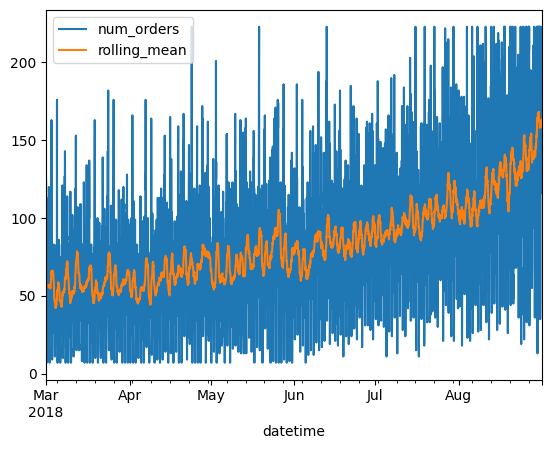

In [10]:
df_1['rolling_mean'] = df_1.rolling(24).mean()
df_1.plot()

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Buena visualización de la media movil de los datos.
</div>

Los datos no se pueden analizar con la gráfica y la media móvil, por lo que se procede con tendencias y estacionalidad. 

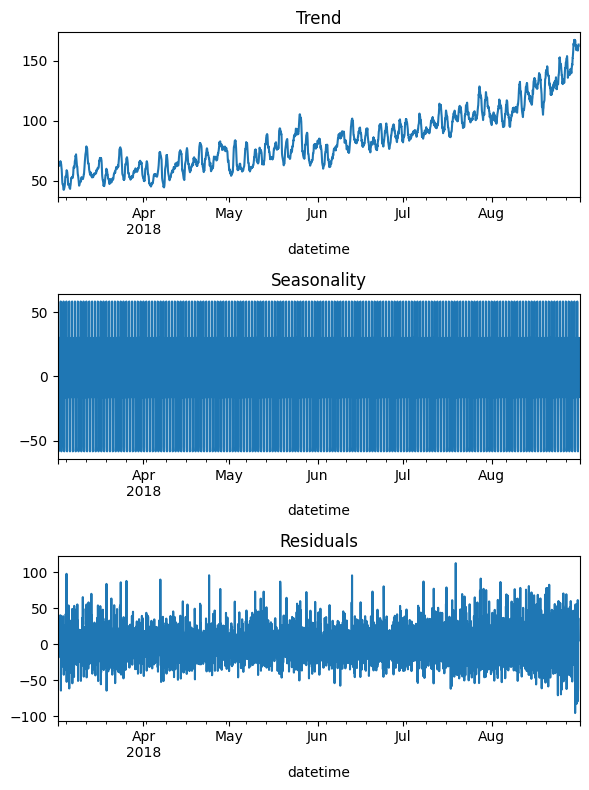

In [11]:
df_sea = df_1.dropna()
decomposed = seasonal_decompose(df_sea['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Perfecto! Los datos se descompusicieron correctamente es tendencia, estacionalidad y residuos.
</div>

-Hay una tendencia en aumento en el pedido de taxis conforme el final del año se aproxima.    
-La estacionalidad se mantiene como un patrón repetitivo, en nuestro caso, se hace por día (24 fragmentos de una hora).    
-Los residuos indican, al final, que el patrón que se lleva a lo largo del tiempo se rompe, por lo que habrán de transformarse los datos para poder obtener análisis más objetivos. 

<AxesSubplot:xlabel='datetime'>

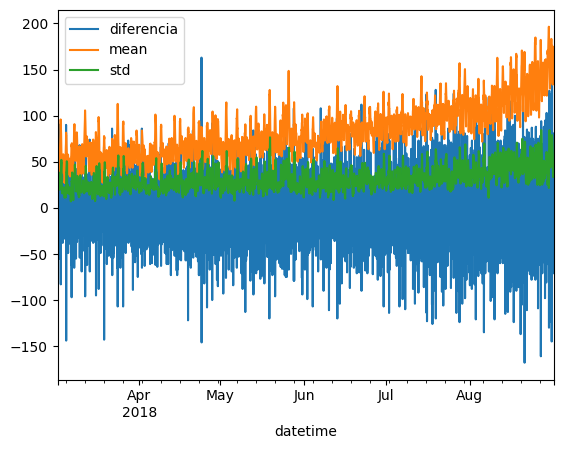

In [12]:
df_sea = df_1.dropna().copy()

df_sea['diferencia'] = df_sea['num_orders'] - df_sea['num_orders'].shift()
df_sea['mean'] = df_sea['num_orders'].rolling(10).mean()
df_sea['std'] = df_sea['num_orders'].rolling(10).std()
df_sea[['diferencia', 'mean', 'std']].plot()

-Hay un aumento de variabilidad al final del periodo de tiempo, lo ucal indica que el número de pedidos tiende a aumentar. Podría deberse a que se aproximan las fechas decembrinas.   
-Se confirma el aumento que se había visto ya se había visto en la tendencia de la gráfica anterior.    
-La desviación estándar también amenta al final del periodo de tiempo, así que hay mayor variabilidad en los pedidos más actuales. 

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Buenos comentarios.
</div>

## Formación

Se segmenta el dataframe para el entrenamiento de modelo de persistencia. Primero se separa el 10% que se utilizará para la prueba.

In [13]:
temp, prueba = train_test_split(df_1, shuffle=False, test_size=.1)

print(temp.index.min(), temp.index.max())
print(prueba.index.min(), prueba.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


El período de prueba para utilizar una vez se haya elegido el modelo adecuado, es del 13 al 31 de agosto.   

Ahora, se segmenta en entrenamiento y validación para el entrenamiento de modelos. Se usará una proporción de 4:1.

In [14]:
train, test = train_test_split(temp, shuffle=False, test_size=.2)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-07-11 10:00:00
2018-07-11 11:00:00 2018-08-13 13:00:00


El segmento de entrenamiento ha quedado del 1 de marzo al 11 de julio, mientras que el validación(test) ha quedado del 11 de julio al 13 de agosto.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Muy bien, dividiste correctamente los datos en entrenamiento y prueba.
</div>

### Modelo 1: Modelo de Persistencia

In [15]:
print('Pedidos de taxis promedio diario:', test['num_orders'].mean())

pred_previo = test.shift()
pred_previo.iloc[0] = train.iloc[-1]
print('EAM', mean_absolute_error(test, pred_previo))
print('El error promedio es de',  mean_squared_error(test, pred_previo)**.5)

Pedidos de taxis promedio diario: 105.96477987421383
EAM 17.907678197064993
El error promedio es de 31.024343600362172


El error absoluto del modelo de persitencia es de 18 taxis por hora, sin embargo, el error cuadrático nos indica que habría hasta 31 errores por hora.

**Se preparan características para entrenamiento de modelos**

In [16]:
def crear_características (data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range (1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()    

In [17]:
crear_características(df_1, 5, 7)
print(df_1.head())

                     num_orders  rolling_mean  year  month  day  dayofweek  \
datetime                                                                     
2018-03-01 00:00:00         124           NaN  2018      3    1          3   
2018-03-01 01:00:00          85           NaN  2018      3    1          3   
2018-03-01 02:00:00          71           NaN  2018      3    1          3   
2018-03-01 03:00:00          66           NaN  2018      3    1          3   
2018-03-01 04:00:00          43           NaN  2018      3    1          3   

                     lag_1  lag_2  lag_3  lag_4  lag_5  
datetime                                                
2018-03-01 00:00:00    NaN    NaN    NaN    NaN    NaN  
2018-03-01 01:00:00  124.0    NaN    NaN    NaN    NaN  
2018-03-01 02:00:00   85.0  124.0    NaN    NaN    NaN  
2018-03-01 03:00:00   71.0   85.0  124.0    NaN    NaN  
2018-03-01 04:00:00   66.0   71.0   85.0  124.0    NaN  


Se hace la segmentación (que tendrá los valores anteriormente mencionados), y se crean features y target para entrenamiento de modelos de regresión. 

In [18]:
temp, prueba = train_test_split(df_1, shuffle=False, test_size=0.1)
print(temp.shape)
print(prueba.shape)
train, test = train_test_split(temp, shuffle=False, test_size=0.2)
train = train.dropna()
print(train.shape)
print(test.shape)

(3974, 11)
(442, 11)
(3172, 11)
(795, 11)


In [19]:
feat_train = train.drop(['num_orders'], axis=1)
tar_train = train['num_orders']
feat_test = test.drop(['num_orders'], axis=1)
tar_test = test['num_orders']

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Excelente! Construiste correctamente las columnas del lag.
</div>

### Linear Regression

In [20]:
model_lin = LinearRegression()
model_lin.fit(feat_train, tar_train)

pred_lin = model_lin.predict(feat_test)

print('Pedidos de taxis promedio diario:', train['num_orders'].mean())
print('El error promedio es de', mean_squared_error(tar_test, pred_lin)**.5)

Pedidos de taxis promedio diario: 71.30422446406052
El error promedio es de 36.950466075301364


Con un promedio diario de 71 taxis, el modelo de Linear Regression nos da un error promedio por hora de 36.95 taxis, lo cual es el 51% de error. Es un promedio alto.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Bien hecho. La regresión lineal se ha entrenado adecuadamente.
</div>

### DecisionTreeRegressor

In [21]:
model_tree = DecisionTreeRegressor(random_state=42, max_depth=5)
model_tree.fit(feat_train, tar_train)

pred_tree = model_tree.predict(feat_test)

print('El error promedio es de', mean_squared_error(tar_test, pred_tree)**.5)

El error promedio es de 43.148154653715366


Ahora se modifican hiperparámetros para mejorar rendimiento de DecisionTreeRegressor.

In [22]:
tree = DecisionTreeRegressor(random_state=42)

parámetros = {
    'max_depth' : [5, 10, 15, 20, None],
    'min_samples_split' : [2, 5, 10, 20],
    'min_samples_leaf' : [1, 2, 5, 10],
    'max_leaf_nodes' : [None, 10, 20, 30, 50, 100]
}

params_ran = RandomizedSearchCV(estimator=tree,
                                param_distributions = parámetros,
                                n_iter=50,
                                cv=5,
                                random_state=42,
                                n_jobs=-1
                               )

params_ran.fit(feat_train, tar_train)

print('Mejores Hiperarámetros:', params_ran.best_params_)

Mejores Hiperarámetros: {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_leaf_nodes': 20, 'max_depth': None}


In [23]:
model_tree_1 = DecisionTreeRegressor(random_state=42, max_depth=None,
                                   min_samples_split=10,
                                   min_samples_leaf=10,
                                   max_leaf_nodes=20
                                  )

model_tree_1.fit(feat_train, tar_train)

pred_tree_1 = model_tree_1.predict(feat_test)

print('El error promedio es de', mean_squared_error(tar_test, pred_tree_1)**.5)

El error promedio es de 43.15220298730735


El erro promedio usando DecisionTreeRegressor con los hiperparámetros modificados, se redujo en un punto, y queda en 43.15.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Bien hecho. El árbol de decisión se exploró correctamente con validación cruzada, estos valores para sus hiperparámetros son correctos.
</div>

### RandomForestRegressor

In [24]:
model_for = RandomForestRegressor(random_state=42,
                                  max_depth=5,
                                  n_estimators=50)
model_for.fit(feat_train, tar_train)
pred_for = model_for.predict(feat_test)

print('El error promedio es de', mean_squared_error(tar_test, pred_for)**.5)

El error promedio es de 39.805360877142434


Se modifican parámetros para mejorar rendimiento del modelo.

In [25]:
forest = RandomForestRegressor(random_state=42)

parámetros = {
    'max_depth' : [5, 10, 15, 20, None],
    'min_samples_split' : [2, 5, 10, 20],
    'min_samples_leaf' : [1, 2, 5, 10],
    'n_estimators' : [50, 100, 200, 300]
}

params_for = RandomizedSearchCV(estimator=forest,
                                param_distributions = parámetros,
                                n_iter=50,
                                cv=5,
                                random_state=42,
                                n_jobs=-1
                               )

params_for.fit(feat_train, tar_train)

print('Mejores Hiperarámetros:', params_for.best_params_)

Mejores Hiperarámetros: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10}


In [26]:
model_for_1 = RandomForestRegressor(random_state=42,
                                  max_depth=10,
                                  n_estimators=200,
                                  min_samples_split=10,
                                  min_samples_leaf=2)
model_for_1.fit(feat_train, tar_train)
pred_for_1 = model_for_1.predict(feat_test)

print('El error promedio es de', mean_squared_error(tar_test, pred_for_1)**.5)

El error promedio es de 38.82403689917527


El cambio de parámetros para RandomForestRegressor disminuyó en un punto el error promedio, y quedó en 38.

Los modelos resultaron en varios RECM:   
-El modelo de persistencia, arrojó un RECM de 31 viajes.   
-El modelo de DecisionTreeClasiffier arrojó un RECM de 36.95 con los hiperparámetros ideales.   
-El modelo de RandomForestregressor arrojó un RECM de 38.82 con los hiperparámetros ideales.    
Dados los resultados de los modelos y sus variaciones en hiperparámetros, el mejor demostró ser el de **persistencia** para la predicción de viajes de la siguiente hora. 

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Muy bien! El bosque aleatorio se ha entrenado adecuadamente. Este modelo casi siempre tiene mejores resultados que un solo árbol de decisión.
</div>

## Prueba

Primero se ejecuta el modelo con los datos a los que se quitaron valores anómalos.

In [28]:
pred_previo = prueba.shift()
pred_previo.iloc[0] = train.iloc[-1]


print('Pedidos de taxis promedio diario:', test['num_orders'].mean())
print('El error promedio es de', mean_squared_error(prueba, pred_previo)**.5)

Pedidos de taxis promedio diario: 105.96477987421383
El error promedio es de 37.264542320949175


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Bien, lograste cumplir el umbral solicitado para el error.
</div>

Ahora se define la predicción para la próxima hora con base en el modelo elegido. 

In [29]:
último_valor = df_1.iloc[-1]['num_orders']
siguiente_hora = [último_valor] * 1

print(siguiente_hora)

[205.0]


## Conclusiones

-Según los análisis realizados con los modelos de regresión y el de persistencia, el que mejor funcionó para la predicción de la siguiente hora, fue el de persistencia, con un error de 37 con el segmento de prueba.    
-Se recomienda el uso del modelo de persistencia con cautela: si bien, nos ayuda a conocer el valor de la siguiente hora, si se quisiesen predicciones para una mayor cantidad de horas, habríase d eusar el modelo RandomForestRegressor que quedó muy cerca del valor del error promedio. Esto ya que el modelo de persistencia conllevaría repetir el mismo valor por las siguientes horas.    
-El modelo de persistencia, arrojó un RECM de 31 viajes.   
-El modelo de DecisionTreeClasiffier arrojó un RECM de 36.95 con los hiperparámetros ideales.   
-El modelo de RandomForestregressor arrojó un RECM de 38.82 con los hiperparámetros ideales.   
-Asimismo, se aclara que se retiraron los valores anómalos para la ejecución de los modelos.    
-Para terminar: según el modelo de persistencia, en la siguiente hora se podrían llegar a registrar de 168 a 242 viajes.

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Buen trabajo. Solo faltan las conclusiones y tu proyecto estará completo.
</div>

<div class="alert alert-block alert-info">
<b>Listo, conclusiones añadidas. Una disculpa, pensé que se requería solamente el valor de la predicción final, sin embargo, no volverá a pasar: siempre agregaré las conclusiones al final del proyecto. Gracias por la retroalimentación. Buen día.</b> <a class="tocSkip"></a>
</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Muchas gracias! Puedo aprobar tu proyecto, éxito en los siguientes sprints.
</div>

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48